## Worksheet 9

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hydro_routines_2d as hydro2d

#### Computational Fluid Mechanics II– Finite volume in 2D

##### a) Run the diagonal advection test from the lecture for a Gaussian density peak. Use a similar set-up for density and pressure as for the 1D advection....

First we set up the simulation parameters, with a constant velocity (u,v) = (1,1) and the pressure P0 constant at 0.1 and the rest of the parameters (t start = 0 and t end = 2).

In [2]:
# 1. simulation parameters
N       = 64 # grid cells per dimension
Lbox    = 1.0 # domain is [0,1) × [0,1)
dx      = Lbox / N
gamma   = 1.4 
CFL     = 0.9
t_end   = 2.0
output_times = [1.0, 2.0] # store snapshots close to these


# primitive background state
rho0    = 1.0
P0      = 0.1
u0, v0  = 1.0, 1.0  # diagonal flow

Then we Initialize the 2D Gaussian density profile, initially centered. 

In [3]:
# Gaussian bump parameters
amp     = 1.0  # peak height above background
sigma   = 0.05 * Lbox
x0, y0  = 0.5 * Lbox, 0.5 * Lbox # initial centre


# 2. initial conditions on the cell centres
x = (np.arange(N) + 0.5) * dx
y = (np.arange(N) + 0.5) * dx
X, Y = np.meshgrid(x, y, indexing='ij')

rho = rho0 + amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma**2)

We set up the initial primitive variables and convert them to the conserved ones, using the funtion `primitive_to_conserved` from the python file

In [4]:
# pack primitive array Q[...,0:4] = (ρ,u,v,P)
Q = np.empty((N, N, 4))
Q[..., 0] = rho
Q[..., 1] = u0
Q[..., 2] = v0
Q[..., 3] = P0

# convert to conserved variables U[...,0:4] = (ρ,ρu,ρv,E)
U = hydro2d.primitive_to_conserved(Q, gamma)

Then we implement the integration timeloop, which is a while-loop that calls the 'hydro_step_unsplit' function until the total time reaches t=2.0. The CFL-limited time-step is chosen automatically each iteration.

In [5]:
# 3. time-integration loop
snapshots = {}
t, step = 0.0, 0
while t < t_end - 1e-14: # tiny tolerance
    # advance with the unsplit scheme (Strang–unsplit also works)
    U, t, step = hydro2d.hydro_step_unsplit(
        U, t=t, tmax=t_end, step=step,
        CFLfac=CFL, dx=dx, gamma=gamma
    )

    # store snapshots the first time we pass an output time
    for tt in output_times:
        if (tt not in snapshots) and (t >= tt):
            snapshots[tt] = hydro2d.conserved_to_primitive(U.copy(), gamma)

print(f"done: {step} steps,  t = {t:.6f}")

done: 392 steps,  t = 2.000000


At last, we plot the solution: We output snapshots. As soon as the running time passes t=1 and t=2 the code records a copy of the primitive variables. These are later compared to the initial field.

L1 error in ρ at t = 1.0: 4.662e-03
L1 error in ρ at t = 2.0: 6.424e-03


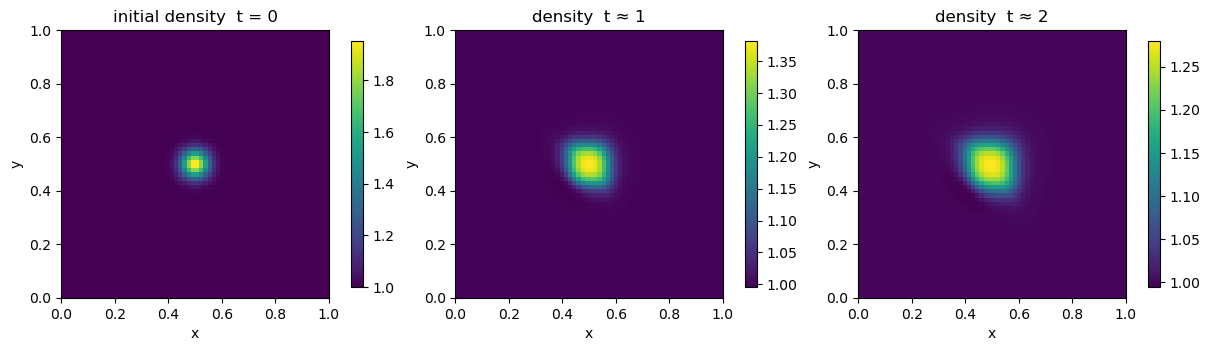

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

def show_density(ax, Qsnap, title):
    im = ax.imshow(Qsnap[..., 0].T, origin='lower', extent=[0, 1, 0, 1])
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

show_density(axes[0], Q,              'initial density  t = 0')
show_density(axes[1], snapshots[1.0], 'density  t ≈ 1')
show_density(axes[2], snapshots[2.0], 'density  t ≈ 2')

# L1-error of density at t = 1, 2  (should be small – pure advection)
for tt in output_times:
    err = np.abs(snapshots[tt][..., 0] - Q[..., 0]).sum() / (N * N)
    print(f"L1 error in ρ at t = {tt:3.1f}: {err:.3e}")

plt.show()

The plots show the density at t=0,1,2.
Because the flow advects the bump one full box length per unit time, the exact solution after 1 and 2 box-crossings is identical to the start; the script prints the L¹-error to confirm the solver’s accuracy.

Left plot ($t=0$):  a perfectly round, bright-yellow Gaussian "blob" centred at `(0.5,0.5)` on a uniform background.

Middle plot ($t=1$):  the blob has moved diagonally by one full box length and has just re-entered the domain through the lower-left periodic boundary. Its peak value is a bit lower and its outline now looks slightly square.

Right plot($t=2$): another full crossing later: the peak is broader and more flattened than at $t\approx 1$  and the squaring is more pronounced.


What the deviations mean:
- Lower peak & broader footprint – numerical viscosity inherent in the Riemann solver smooths gradients, spreading mass over neighbouring cells.

- Squarish outline – the limiter constructs slopes only along the grid axes, so an initially isotropic blob picks up a mild grid-aligned anisotropy.

- Error growth – the printed L¹-errors quantify the integrated absolute difference from the initial density. A few $10^{-3}$ on a background of 1 is well within expectations for a second-order scheme at this resolution.

If we f.e. switch to the split integrator, we can see a faster diffustion.


#### The complete mainn driver function: 

In [7]:
# Main driver function: 
# function to run one advection simulation and return L1 error and average dt 
def run_sim(N, CFLfac, t_end=1.0, gamma=5.0/3.0, amp=1.0, P0=0.1, u0=1.0, v0=1.0):
    """
    Run one diagonal-advection test and return
        Δx (= 1/N),  ⟨Δt⟩  (average time-step),  and L1-error of ρ at t_end
    """
    Lbox = 1.0
    dx = Lbox / N
    # grid
    x = (np.arange(N) + 0.5) * dx
    y = (np.arange(N) + 0.5) * dx
    X, Y = np.meshgrid(x, y, indexing='ij')
    # initial primitive state
    rho0 = 1.0 + amp * np.exp(-((X-0.5)**2 + (Y-0.5)**2) / (0.05**2))
    Q = np.empty((N, N, 4))
    Q[...,0] = rho0
    Q[...,1] = u0
    Q[...,2] = v0
    Q[...,3] = P0
    U = hydro2d.primitive_to_conserved(Q, gamma)
    # time loop
    t = 0.0
    step = 0
    total_dt = 0.0
    while t < t_end - 1e-12:
        U, t, step = hydro2d.hydro_step_unsplit(U, t=t, tmax=t_end, step=step,
                                                CFLfac=CFLfac, dx=dx, gamma=gamma)
    avg_dt = t_end / step
    # convert back
    Q_end = hydro2d.conserved_to_primitive(U, gamma)
    err = np.abs(Q_end[...,0] - Q[...,0]).sum() / (N*N)
    return dx, avg_dt, err

##### b) Determine the order of convergence of the method by plotting the error between the advected solution at t = 1 and the initial condition (as usual in a log-log plot) against the resolution– varying first the spatial resolution and then the time step size (by adjusting CFLfac ). Measure the order of the method by fitting the slope.

First we vary the spacial resolution by varying N and measure the order of the metod fitting a linear fit using `np.polyfit`

In [8]:
# 1) spatial convergence: vary N
Nlist = [32, 64, 128]  # Breaks down after 128 (or takes forever idk, I let it run for 10 mins, didnt finish)
dxs, errs_dx = [], []
for N in Nlist:
    dx, avg_dt, err = run_sim(N=N, CFLfac=0.5)
    dxs.append(dx)
    errs_dx.append(err)

# linear fit in log space
p_dx = np.polyfit(np.log10(dxs), np.log10(errs_dx), 1)
order_space = p_dx[0]

Now we vary the time step size, by adjusting CFLfac

In [9]:
# 2) temporal convergence: vary CFLfac (dt size) at fixed resolution
N_fixed = 64
CFLlist = [0.05, 0.1, 0.2, 0.4, 0.8, 0.9]  # Going above 1 is unsafe; going below 0.05 just wastes CPU time without noticeable accuracy gains in most cases.
dts, errs_dt = [], []
for cfl in CFLlist:
    dx, avg_dt, err = run_sim(N=N_fixed, CFLfac=cfl)
    dts.append(avg_dt)
    errs_dt.append(err)

p_dt = np.polyfit(np.log10(dts), np.log10(errs_dt), 1)
order_time = p_dt[0]

Now we plot the results and the convergence order (fittet slope) 

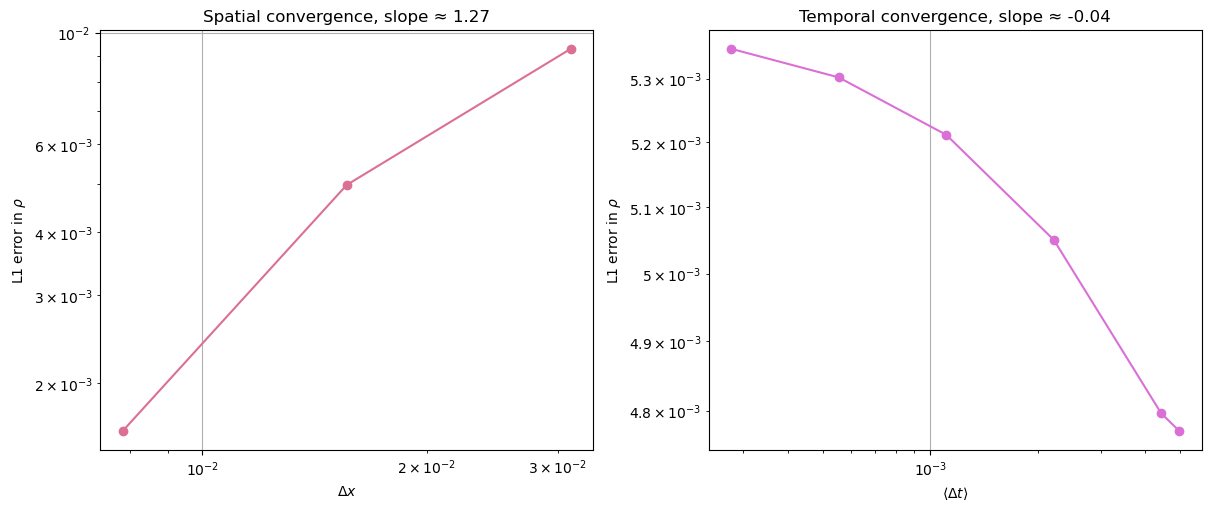

Spatial convergence order (slope): 1.2661967696881484
Temporal convergence order (slope): -0.04148013790192952


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Spatial convergence
plt.sca(axes[0])   
plt.loglog(dxs, errs_dx, marker='o', linestyle='-', color='palevioletred')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'L1 error in $\rho$')
plt.title(f'Spatial convergence, slope ≈ {order_space:.2f}') 
plt.grid(True)

# Temporal convergence
plt.sca(axes[1])    
plt.loglog(dts, errs_dt, marker='o', linestyle='-', color='orchid')
plt.xlabel(r'$\langle \Delta t \rangle$')
plt.ylabel(r'L1 error in $\rho$')
plt.title(f'Temporal convergence, slope ≈ {order_time:.2f}')
plt.grid(True)
plt.show()

print("Spatial convergence order (slope):", order_space)
print("Temporal convergence order (slope):", order_time) 

If we have: `Nlist = [16, 32, 64]`, it does not reach second order accuracy. Therefore we increased it to 128, however, after that it took forever to run. 

In the left plot: we see that the error halves when the mesh spacing halves ⟹ first-order spatial convergence in this experiment, with a slope of $\approx 1.27$.

In the right plot we see a very shallow, skightly negative slope of $\approx - 0.04$. we see that the error hardly changes when shortening the time step ⟹ it is dominated by spatial truncation and temporal errors are buried in the noise.


''' Ignore
- The line behaviour in each log–log plot should indicate a power-law error $\propto \triangle x^p$ or $err \propto (\triangle t)^p $

- `np.polyfit` on the $\log_{10}$ values gives the slope **p**, the measured order.
- For this solver and smooth advection you should find p ≈ 2 in both cases,
confirming second-order accuracy in space and time. '''

However, we observe a different behaviour in both plots...:(

##### c) Sedov-Taylor blast wave

Next up we will set up a Sedov-Taylor blast wave. For the initial conditions we set the density $\rho =1$, the velocity $v=0$ and pressure to $P=0.001$ everywhere. We will set one central cell to have high pressure of $P=10$. 

In [11]:
def sedov_initial_conditions(N, rho0, v0, P0, P_peak, gamma=1.4):
    Q = np.zeros((N, N, 4))
    Q[..., 0] = rho0    #Density
    Q[..., 1] = v0      #u
    Q[..., 2] = v0      #v
    Q[..., 3] = P0      #Pressure

    i0, j0 = N // 2, N // 2 
    Q[i0, j0, 3] = P_peak  # Set peak pressure at the center

    U = hydro2d.primitive_to_conserved(Q, gamma)
    return U

In this function we set up the 2D grid of the size NxN. It fills the domain with the density $\rho_0$, velocity $v_0$ and pressure of the background $P_0$, which we store in $Q$ with the shape of (N, N, 4). This is our pre-explosion state. We set the  explosion energy at the central cell. It mimics a delta-function energy input. This acts like a point-source blast. We then Converts primitive to conserved variables.

In [12]:
def radial_profile(Qsnap, center, dx):
    N = Qsnap.shape[0]
    i, j = np.indices((N, N))
    x = (i + 0.5) * dx
    y = (j + 0.5) * dx
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    rho = Qsnap[..., 0]
    u = Qsnap[..., 1]
    v = Qsnap[..., 2]
    P = Qsnap[..., 3]
    vrad = (u * (x - center[0]) + v * (y - center[1])) / (r + 1e-10) # radial velocity component

    return r.ravel(), rho.ravel(), P.ravel(), vrad.ravel()

In this function we compute the radial distance $r$ of every cell from the center. It extracts the density $\rho$, pressure $P$ and the radial velocity $v_{rad}, projected from the $u$ and $v$ components. We build arrays of cell-centered coordinates. $(i+0.5)$ shifts to center of each cell. We calculate the radial distance from center of explosion. We then project the velocity vector onto the radial direction using the dot product:

$v_r = \frac{\vec{v} \cdot \vec{r}}{|\vec{r}|} = \frac{u(x-x_0) + v(y-y_0)}{r + \epsilon}$

We then flatten all arrays to 1D sow we can use them in scatter plots.

In [13]:
def run_sedov_sim(N, P_peak, t_end=1.0, gamma=1.4, CFL=0.9):
    dx = 1.0 / N
    U = sedov_initial_conditions(N, rho0=1.0, v0=0.0, P0=0.001, P_peak=P_peak, gamma=gamma)
    t, step = 0.0, 0
    snapshots = {}

    output_times = [0.5, 1.0]
    while t < t_end - 1e-12:
        U, t, step = hydro2d.hydro_step_unsplit(U, t=t, tmax=t_end, step=step, CFLfac=CFL, dx=dx, gamma=gamma)
        for tt in output_times:
            if(tt not in snapshots) and (t >= tt):
                snapshots[tt] = hydro2d.conserved_to_primitive(U.copy(), gamma)
    
    return snapshots, dx

Here we run the simulation. First we set an initial state $U$ from our Sedov function. We then prepare to store the data at key time steps. It runs it through the 2D hydro solver from hydro_routines_2d.py. It then stores a copy of the solution in primitive form at $t=0.5$ and $t=1.0$.

In [14]:
def plot_profiles(snapshots, dx, N, label_prefix=''):
    center = (0.5, 0.5)  # Center of the domain
    for  t in [0.5, 1.0]:
        if t in snapshots:
            Q = snapshots[t]
            r, rho, P, vrad = radial_profile(Q, center, dx)
            plt.figure(figsize=(14, 4))

            for i, (y, name) in enumerate(zip([rho, P, vrad], ['Density', 'Pressure', 'Radial Velocity'])):
                plt.subplot(1, 3, i + 1)
                plt.scatter(r, y, s=1, label=f'{label_prefix} t={t}')
                plt.xlabel('Radius (r)')
                plt.ylabel(name)
                plt.title(f'{name} profile at t={t}')
                plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

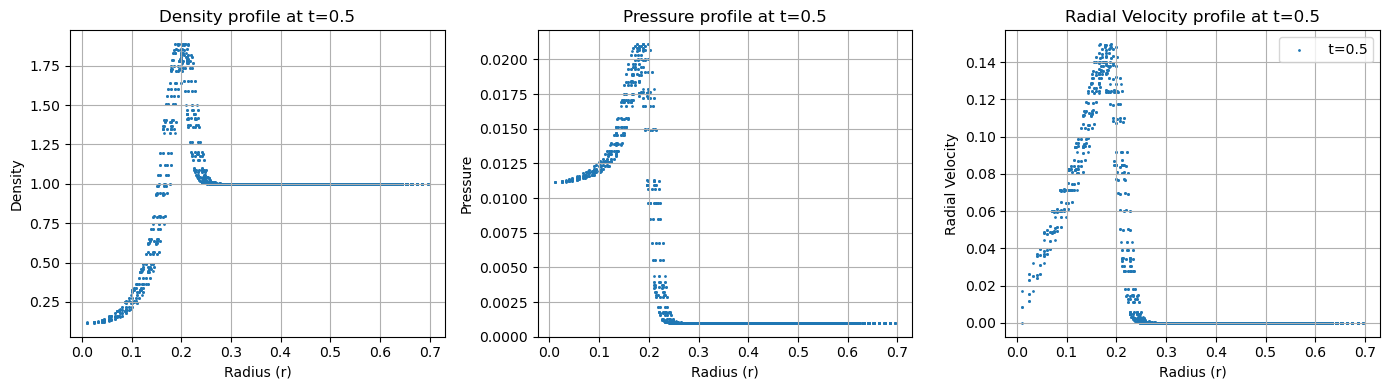

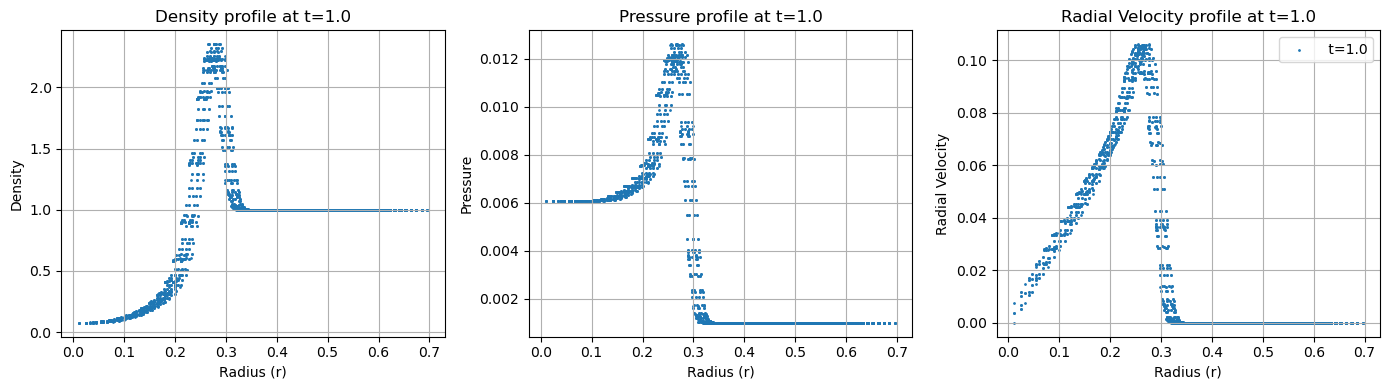

In [15]:
N = 64
P_peak = 10.0
snapshots, dx = run_sedov_sim(N=N, P_peak=P_peak)
plot_profiles(snapshots, dx, N)

In the plots for a resolution of $64$ we can see:

At $t=0.5$:
- The density rises steeply at a certain radius, indicating the propagating shock front.
- Pressure shows a strong central peak with a steep drop, typical of energy initially concentrated in the center.
- Radial velocity rises up to a peak just behind the shock front, then falls, consistent with outward motion behind the blast.

At $t=1.0$:
- Density peak has increased slightly.
- Pressure has decreased from the peak at $t = 0.5$, as energy spreads over a larger volume.
- Velocity shows a smoother curve, again peaking just behind the shock.


In [16]:
def scaled_peak_pressure(N, gamma=1.4, E_blast=1.0):
    dx = 1.0 / N
    return E_blast * (gamma - 1) / dx**2

To ensure that the total explosion energy remains constant as we change the resolution, the peak pressure in the central cell must be scaled with resolution. Since in 2D the energy in a single cell is given by:

$E = \frac{P\cdot dx^2}{\gamma - 1}$ 

we solve for pressure:

$P = \frac{E\cdot(\gamma - 1)}{dx^2}$

As the cell size $dx$ decreases with higher resolution $(dx =1/N)$, the deposition volume $dx^2$ shrinks. To compensate, the central peak pressure must increase.

Now for each resolution we:
- Scale the pressure peak properly.
- Run the full simulation.
- Plot the results.

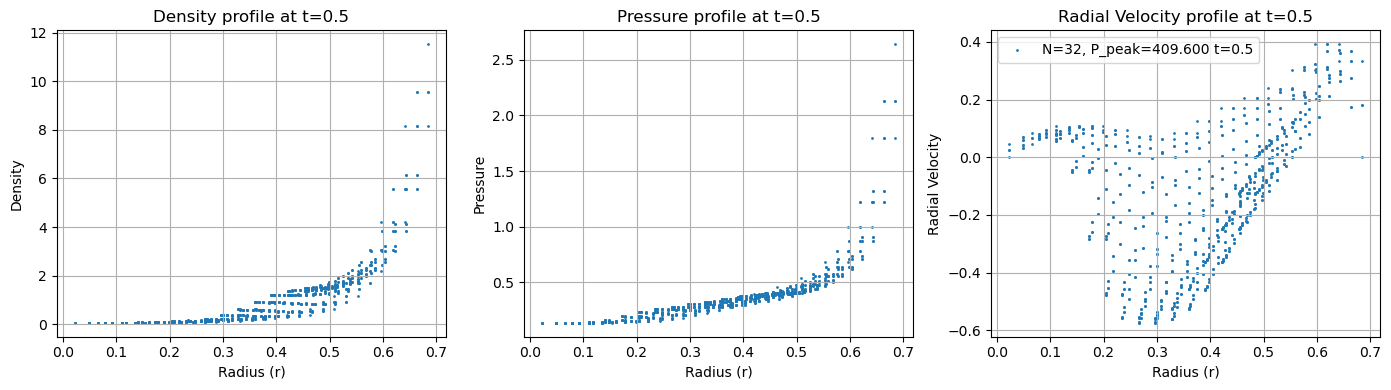

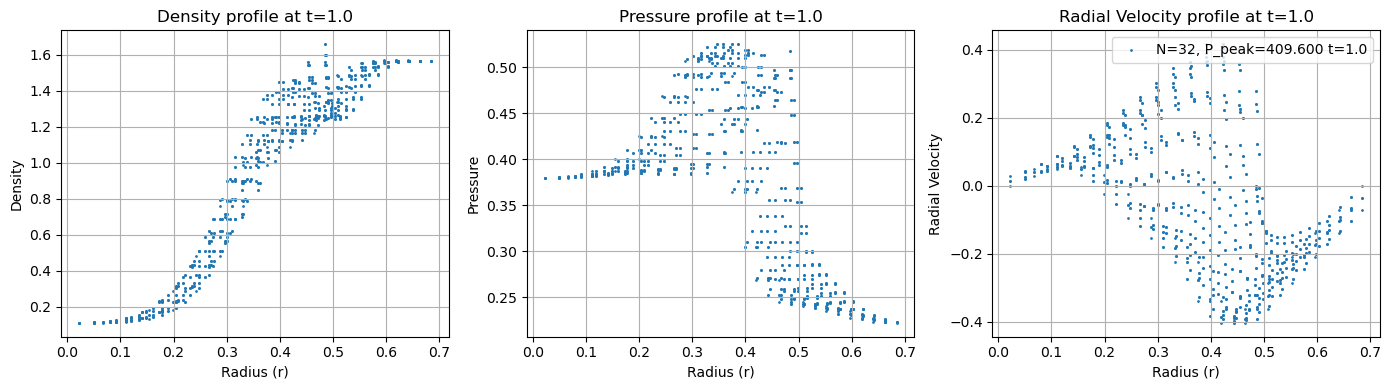

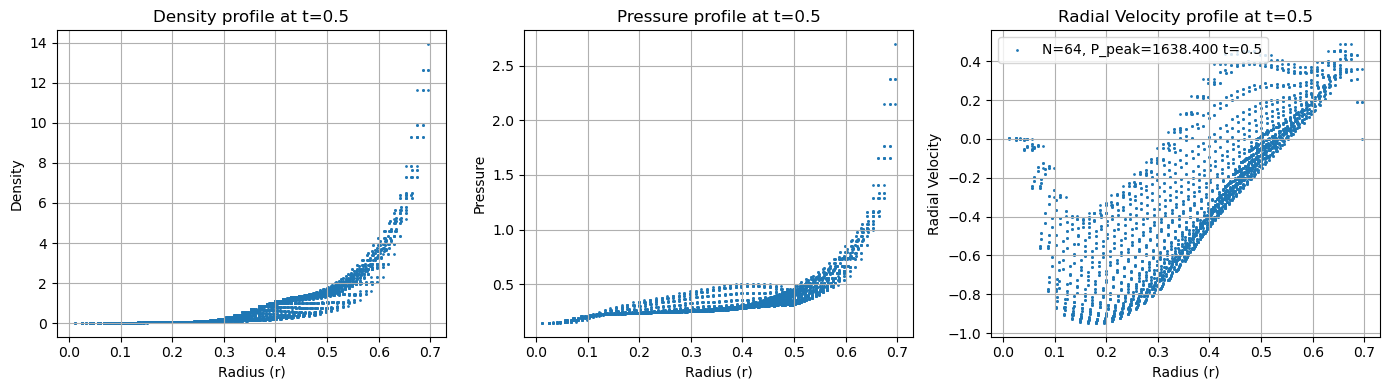

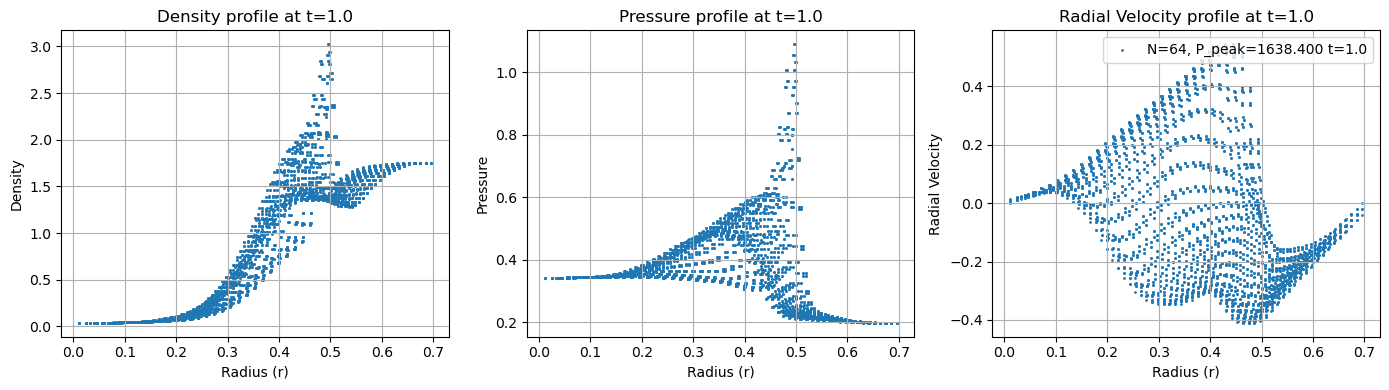

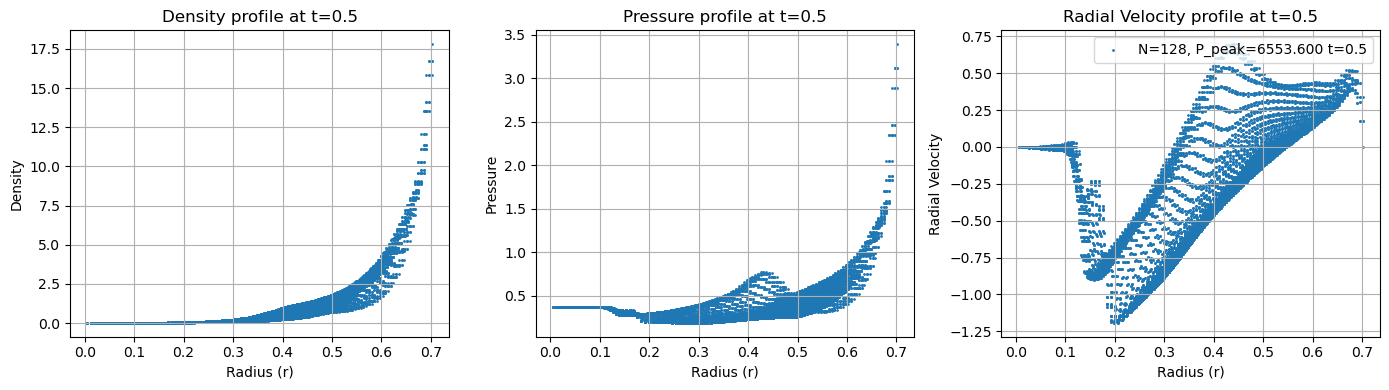

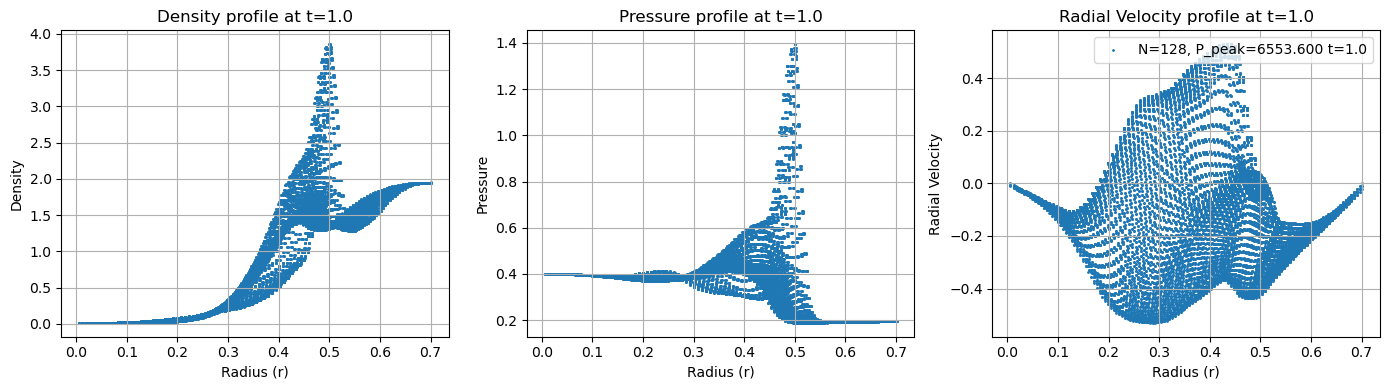

In [17]:
res_list = [32, 64, 128]
for N in res_list:
    P_peak =scaled_peak_pressure(N, gamma=1.4, E_blast=1.0)
    snapshots, dx = run_sedov_sim(N, P_peak=P_peak, t_end=1.0, gamma=1.4, CFL=0.9)
    plot_profiles(snapshots, dx, N, label_prefix=f'N={N}, P_peak={P_peak:.3f}')

In the plots we can see in each row:
- Left: Density profile vs radius
- Middle: Pressure profile vs radius
- Right: Radial velocity vs radius

For each resolution (32, 64, 128) we have two columns of these plots. Each column compares profiles at $t=0.5$ and $t=1.0$ for each resolution. We chose these resolution, as higher ones took a significant amount of more time.

$N = 32$ (Low Resolution):
$t=0.5$:
- The density increases steep near $r=0.6$, but is noisy.
- The pressure has an exponential-like rise outward and is more smooted due to the resolution
- The radial velocity is mostly negative inside $r<0.4$ due to compression and is positive near the shock (shock front propagating outward).

$t=1.0$:
- The profiles are still noisy, but clearer.
- Pressure and density gradients are smeared.
- The shock front is not sharply defined.

$N = 64$ (Medium Resolution):
$t=0.5$:
- Density and pressure increase much more steeply.
- Shock front is more visible at $r\approx 0.5 - 0.6$
- Radial velocity has a smoother profile with a strong peak near the shock.

$t=1.0$:
- Clear formation of a dense shell.
- Central region is still compressed but less noisy.
- Velocity shows a smoother inward-to-outward gradient.

$N = 64$ (High Resolution):
$t=0.5$:
- The density has a steep gradient, with a pronounced peak, clear shock front.
- The pressure has a flat interior, then a sharp spike at the front.
- The radial velocity captures the rarefaction and acceleration near the front, with complex structure behind.

$t=1.0$:
- The blast wave shell is very well-resolved.
- Pressure peak shifts outward.
- Radial velocity shows complex internal flow, possibly indicating reflected waves or secondary structures in our numerical method.

As time increases:
- The shock radius increases.
- The density shell becomes thinner and denser.
- The pressure peak moves outward.
- The radial velocity peaks shift, reflecting the expanding shock

##### d) Supernova-driven turbulent interstellar medium in 2D

Now we are simulating a 2D interstellar medium (ISM) that becomes turbulent over time due to randomly located supernova explosions. 

In [18]:
def inject_supernova(U, E_SN, dx, gamma):
    N = U.shape[0]
    i, j = np.random.randint(0, N), np.random.randint(0, N)

    Q = hydro2d.conserved_to_primitive(U, gamma)

    dA = dx**2
    P_add = E_SN * (gamma - 1) / dA

    Q[i, j, 3] += P_add

    return hydro2d.primitive_to_conserved(Q, gamma)

In this function we inject energy into the simulation at a random location, representing a supernova explosion. We set up a grid using the shape of the conserved variables that represent the fluid state (density, momentum, energy). 

A random grid cell is selected to receive the energy injection. Since the solver uses conserved variables but the pressure is part of the primitive variables, we first convert $U$ to primitive variables $Q$ (density, velocity components, pressure).

We compute the area of a single grid cell as $dx^2$ (since it's a 2D simulation), and calculate the pressure increase needed to represent the injected energy. This is done using the ideal gas relation:

$P = (\gamma - 1)\cdot energy density$

So we rearrange it to add a pressure amount that corresponds to a fixed energy per unit area:

$P_{add} = \frac{E_{SN}\cdot(\gamma - 1)}{dx^2}$

This ensures that the total injected energy is independent of resolution. We then only modify the pressure of the selected cell, and finally convert back to conserved variables so the solver can proceed with the next update.

In [19]:
def run_turbulent_ism(N, E_SN=1.0, SN_rate=0.01, t_end=5.0, gamma=1.4, CFL=0.9):
    dx = 1.0 / N
    rho0, v0, P0 = 1.0, 0.0, 1e-5
    U = sedov_initial_conditions(N, rho0, v0, P0, P_peak=0.0, gamma=gamma)

    t, step = 0.0, 0
    snapshots = {}

    while t < t_end:
        dt = CFL * hydro2d.get_timestep_from_U(U, dx=dx, gamma=gamma, unsplit=True)

        p = SN_rate * dt
        if np.random.rand() < p:
            U = inject_supernova(U, E_SN, dx, gamma)
        
        U, t, step = hydro2d.hydro_step_unsplit(U, t=t, tmax=t_end, step=step, CFLfac=CFL, dx=dx, gamma=gamma)

        if step % 100 == 0:
            print(f"Step {step}, Time {t:.3f}")
        
        if step % 200 == 0:
            snapshots[t] = hydro2d.conserved_to_primitive(U.copy(), gamma)
        
    return snapshots, dx

This is our main driver function that runs the simulation. We initialize he fluid with uniform density $\rho_0=0$, zero velocity $v_0=0$ and very low initial pressure $P_0=10^{-5}. We use the sedov_initial_conditions() function (from task c) to set this up. In this case, we pass $P_{Peak}=0.0$ so no explosion is initialized manually, as supernovae will now be added randomly over time. 

We initialize simulation time $t=0.0$ and set up a dictionary to store simulation states at certain time steps. These snapshots allow us to later visualize how the turbulence evolves.

While simulation time is less than $t_{end} in the loop, we calculate the timestep $dt$ based on the CFL condition and current state $U$ to maintain numerical stability. We the compute the probability $p=SN_{rate}$ that a supernova explodes during this timestep. We then draw a random number $r$ uniformly between $0$ and $1$ and if $r < p$ the function calls the inject_supernova function to add energy at a random point. We then advance the timestep using the unsplit solver from the hydro_routines.py We print the progress every 100 steps and save snapshots of the primitive variables every 200 steps.

After the loop finishes, we return all snapshots and grid spacing $dx$.

In [20]:
def plot_density(Q, dx, t):
    rho = Q[..., 0]
    plt.imshow(rho.T, origin='lower', extent=[0, 1, 0, 1], cmap='plasma')
    plt.colorbar(label='Density')
    plt.title(f'Density field at t = {t:.2f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

Here we plot the 2D density field at time $t$. We then run the simulation with 128x128 grid, supernova energy $1.0$, high SN rate $1.0$, and simulates until $t=5.0$.

In [21]:
snapshots, dx = run_turbulent_ism(N=128, E_SN=1.0, SN_rate=1.0, t_end=5.0)

Step 100, Time 0.032
Step 200, Time 0.071
Step 300, Time 0.120
Step 400, Time 0.166
Step 500, Time 0.213
Step 600, Time 0.262
Step 700, Time 0.313
Step 800, Time 0.367
Step 900, Time 0.413
Step 1000, Time 0.457
Step 1100, Time 0.505
Step 1200, Time 0.556
Step 1300, Time 0.607
Step 1400, Time 0.659
Step 1500, Time 0.717
Step 1600, Time 0.778
Step 1700, Time 0.843
Step 1800, Time 0.910
Step 1900, Time 0.978
Step 2000, Time 1.049
Step 2100, Time 1.123
Step 2200, Time 1.198
Step 2300, Time 1.272
Step 2400, Time 1.342
Step 2500, Time 1.417
Step 2600, Time 1.505
Step 2700, Time 1.607
Step 2800, Time 1.725
Step 2900, Time 1.850
Step 3000, Time 1.977
Step 3100, Time 2.108
Step 3200, Time 2.230
Step 3300, Time 2.357
Step 3400, Time 2.482
Step 3500, Time 2.602
Step 3600, Time 2.728
Step 3700, Time 2.864
Step 3800, Time 2.995
Step 3900, Time 3.132
Step 4000, Time 3.241
Step 4100, Time 3.282
Step 4200, Time 3.330
Step 4300, Time 3.382
Step 4400, Time 3.389
Step 4500, Time 3.396
Step 4600, Time 3.4

In [22]:
print(f"Snapshots collected: {len(snapshots)}")

Snapshots collected: 55


As were are getting $55$ snapshots, thats alot of plots to go through. So we only plot ever 10th snaphots to check if the simulation is correct and we will then load all of the snapshots into an animation, which looks better.

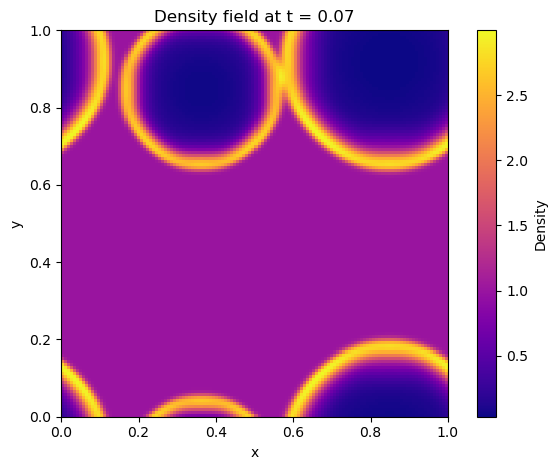

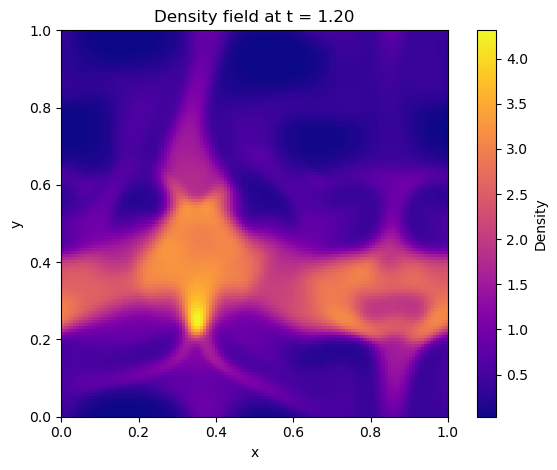

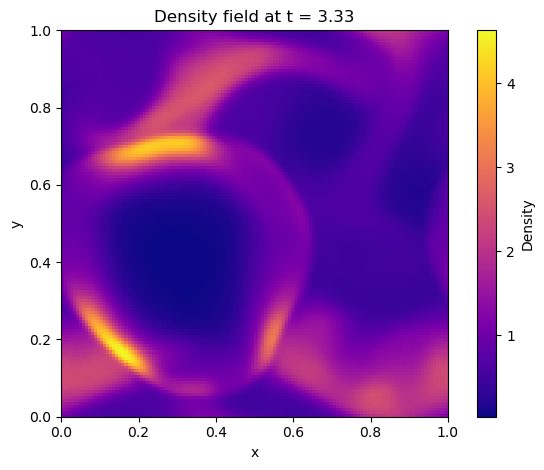

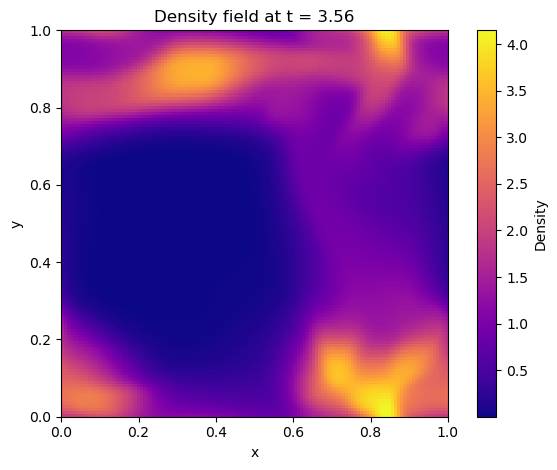

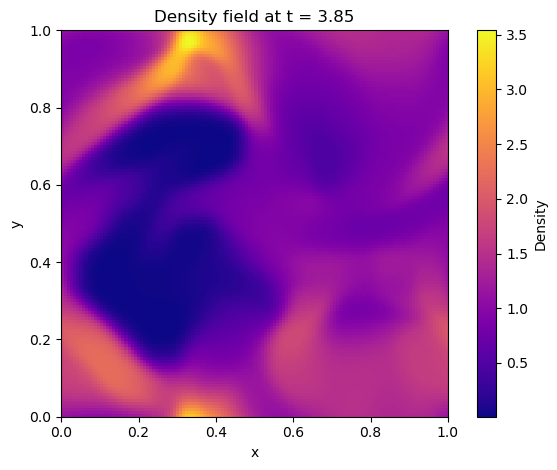

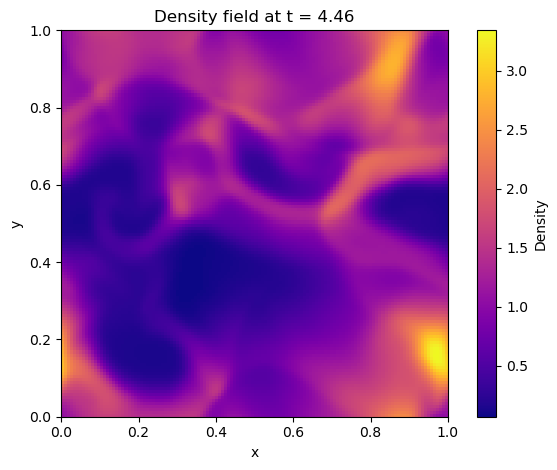

In [25]:
selected_times = sorted(snapshots.keys())[::10]  # Every ~10th snapshot
for t in selected_times:
    plot_density(snapshots[t], dx, t)

Now here we can see the snapshots of the simulation. The simulation starts with the first snapshot at $t=0.07$. In this frame we can see, few supernovae have just exploded. We can see clear circular shock fronts expanding out. In the subsequent shocks we can see that the shock fronts begin to overlap and interact. The ISM gets more turbulent, forming complex density structures. In the last three frames we can see that the box becomes fully turbulent. We see filamentary structures, compressed regions, and a broad range of densities.

This can all be seen better in an animation, which we will now generate with our produced snaphots.

In [26]:
import matplotlib.animation as animation

def animate_snapshots(snapshots, dx):
    times = sorted(snapshots.keys())
    fig, ax = plt.subplots(figsize=(6, 5))
    
    rho = snapshots[times[0]][:, :, 0]
    extent = [0, rho.shape[0] * dx, 0, rho.shape[1] * dx]
    im = ax.imshow(rho.T, origin="lower", extent=extent, cmap="plasma", vmin=0, vmax=np.max(rho))
    title = ax.set_title(f"Density at t = {times[0]:.2f}")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("Density")

    def update(i):
        t = times[i]
        rho = snapshots[t][:, :, 0]
        im.set_data(rho.T)
        title.set_text(f"Density at t = {t:.2f}")
        return [im, title]

    ani = animation.FuncAnimation(
        fig, update, frames=len(times), interval=200, blit=False, repeat=False
    )
    return ani

Here we create an animation showing how the density field evolves over time. We initialize the figure with the first snapshot. We then define update function to change the density plot and title for each frame. We use FuncAnimation to generate the frames. We save the animation as a gif.

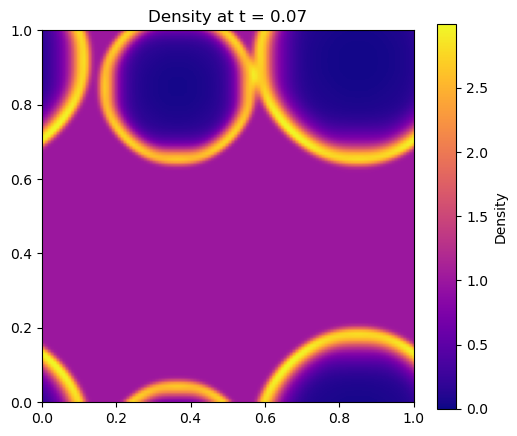

In [27]:
ani = animate_snapshots(snapshots, dx)
ani.save("turbulent_ism.gif", writer="pillow", fps=5)

The animiation shows density evolution in a 2D periodic box, with randomly occurring supernova explosions injecting energy.
- Dark purple regions $\rightarrow$ low density (rarefied gas after explosions)
- Bright yellow rings $\rightarrow$ dense expanding shells (shock fronts from supernovae)
- Smooth light purple background $\rightarrow$ ambient interstellar medium (ISM)

The animation can be fully seen in the attached file "turbulent_ism.gif"